In [2]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from tensorflow import keras;
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [3]:
path = 'book.txt'
text = open(path, encoding='utf-8').read().lower()
print('Total length:', len(text))

Total length: 581888


In [4]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [5]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [6]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [7]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [8]:
print(X[0])
print(Y[0])

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[False False False ... False False False]


In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [11]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
811/811 [==============================] - 189s 230ms/step - loss: 3.4047 - accuracy: 0.5991 - val_loss: 10.0976 - val_accuracy: 0.0582 0s - loss: 3.4049 - accuracy: 0.
Epoch 2/20
811/811 [==============================] - 192s 237ms/step - loss: 3.2701 - accuracy: 0.6141 - val_loss: 10.1787 - val_accuracy: 0.0599
Epoch 3/20
811/811 [==============================] - 200s 246ms/step - loss: 3.2194 - accuracy: 0.6211 - val_loss: 10.4322 - val_accuracy: 0.0617
Epoch 4/20
811/811 [==============================] - 198s 244ms/step - loss: 3.1785 - accuracy: 0.6284 - val_loss: 10.6434 - val_accuracy: 0.0579
Epoch 5/20
811/811 [==============================] - 192s 237ms/step - loss: 3.1420 - accuracy: 0.6332 - val_loss: 10.5741 - val_accuracy: 0.0569
Epoch 6/20
811/811 [==============================] - 193s 238ms/step - loss: 3.1068 - accuracy: 0.6406 - val_loss: 10.9056 - val_accuracy: 0.0538
Epoch 7/20
811/811 [==============================] - 193s 238ms/step - loss: 3.0730 

In [12]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

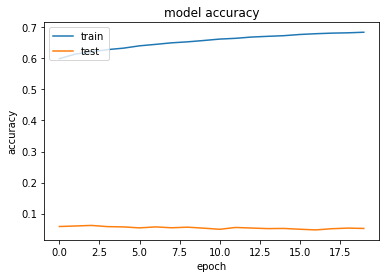

In [13]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

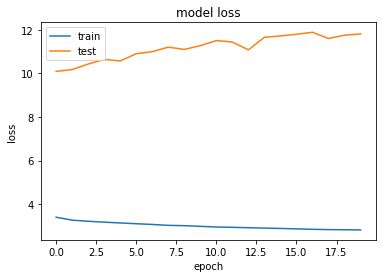

In [14]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [15]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [16]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [17]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [18]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [19]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [20]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
it
is
not
a
lack
of


IndexError: index 5 is out of bounds for axis 1 with size 5